In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math

# ==========================================
# 1. 参数设置
# ==========================================
# Logistic 映射带融合点参数 (Band Merging Point)
U_CRITICAL = 1.543689012692076 

# 样本量设置
# 注意：块熵计算对数据量要求较高，这里生成较多数据以保证统计显著性
PRIME_LIMIT = 5_000_000  # 素数上限
LOGISTIC_STEPS = 500_000 # Logistic迭代步数
MAX_BLOCK_SIZE = 12      # 最大块长度 (k)

# ==========================================
# 2. 数据生成与重整化 (Renormalization)
# ==========================================
def get_normalized_prime_symbols(limit):
    """
    生成素数间隙，并根据局部密度进行重整化和符号化
    规则：Gap / ln(p) > 1 则为 '1' (大间隙)，否则为 '0' (小间隙)
    """
    print(f"1. 生成素数 (Limit={limit})...")
    # 埃拉托斯特尼筛法
    sieve = np.ones(limit // 2, dtype=bool)
    for i in range(3, int(limit**0.5) + 1, 2):
        if sieve[i // 2]:
            sieve[i*i // 2 :: i] = False
    primes = np.array([1] + [2 * i + 1 for i in range(1, limit // 2) if sieve[i]])
    
    # 计算间隙
    gaps = np.diff(primes)
    # 对应的素数位置 (取间隙起始素数)
    p_vals = primes[:-1]
    
    # --- 关键步骤：重整化 (Renormalization) ---
    # 消除 1/ln(n) 的趋势，使其变为平稳序列
    # 避免 ln(2) 导致的除零或过小，从 index 1 开始 (素数3)
    valid_idx = p_vals > 2
    normalized_gaps = gaps[valid_idx] / np.log(p_vals[valid_idx])
    
    # --- 符号化 (Symbolization) ---
    # 将连续数值转化为 0/1 符号序列
    # 1 代表 "比平均间隙大" (逃逸)，0 代表 "比平均间隙小" (滞留)
    symbols = (normalized_gaps > 1.0).astype(int)
    return symbols

def get_logistic_symbols(n_steps, u):
    """
    生成 Logistic 映射的间隙，并符号化
    """
    print(f"2. 生成 Logistic 轨道 (u={u})...")
    x = 0.1
    gaps = []
    current_gap = 0
    
    # 预热
    for _ in range(10000):
        x = 1 - u * x * x
        
    # 迭代
    for _ in range(n_steps):
        x = 1 - u * x * x
        if x < 0: # "素数"事件发生
            if current_gap > 0:
                gaps.append(current_gap)
            current_gap = 1
        else:
            current_gap += 1
            
    gaps = np.array(gaps)
    
    # 归一化 (Logistic 系统本身是平稳的，除以全局均值即可)
    norm_gaps = gaps / np.mean(gaps)
    
    # 符号化
    symbols = (norm_gaps > 1.0).astype(int)
    return symbols

# ==========================================
# 3. 块熵计算 (Block Entropy)
# ==========================================
def calc_block_entropy(sequence, max_k):
    """
    计算不同长度 k 的块熵 H(k) 和 熵率 h(k)
    H(k) = - sum p(w) log2 p(w)
    h(k) = H(k+1) - H(k)
    """
    print("3. 计算块熵...")
    n = len(sequence)
    entropies = []  # H(k)
    
    for k in range(1, max_k + 2):
        # 使用简单的滑动窗口统计频次
        # 注意：这里转为 tuple 以便作为字典 key，比字符串快
        # 为了速度，这里用简单的列表推导，大数据量下可用 scipy/pandas 优化
        if n < k:
            break
            
        # 提取所有长度为 k 的子序列
        # 这种实现方式简单但内存消耗大，生产环境需优化
        blocks = [tuple(sequence[i:i+k]) for i in range(n - k + 1)]
        counts = Counter(blocks)
        total = len(blocks)
        
        H_k = 0
        for count in counts.values():
            p = count / total
            H_k -= p * math.log2(p)
        entropies.append(H_k)
        
    # 计算熵率 h(k) = H(k+1) - H(k)
    entropy_rates = []
    for i in range(len(entropies) - 1):
        h_k = entropies[i+1] - entropies[i]
        entropy_rates.append(h_k)
        
    return entropies[:-1], entropy_rates

# ==========================================
# 4. 主程序与可视化
# ==========================================
def main():
    # A. 获取符号序列
    prime_sym = get_normalized_prime_symbols(PRIME_LIMIT)
    log_sym = get_logistic_symbols(LOGISTIC_STEPS, U_CRITICAL)
    
    print(f"素数序列长度: {len(prime_sym)}")
    print(f"Logistic序列长度: {len(log_sym)}")
    
    # 截取相同长度以保证公平对比
    min_len = min(len(prime_sym), len(log_sym))
    prime_sym = prime_sym[:min_len]
    log_sym = log_sym[:min_len]
    
    # B. 计算熵
    H_prime, h_prime = calc_block_entropy(prime_sym, MAX_BLOCK_SIZE)
    H_log, h_log = calc_block_entropy(log_sym, MAX_BLOCK_SIZE)
    
    ks = np.arange(1, MAX_BLOCK_SIZE + 1)
    
    # C. 绘图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 图1: 块熵 H(k)
    ax1.plot(ks, H_prime, 'b-o', label='Primes (Renormalized)')
    ax1.plot(ks, H_log, 'r-s', label=f'Logistic (u={U_CRITICAL:.4f})')
    # 添加参考线：完全随机序列 H(k) = k (H(1)=1 bit)
    ax1.plot(ks, ks, 'k--', alpha=0.3, label='Pure Random (H=k)')
    
    ax1.set_title('Block Entropy H(k)')
    ax1.set_xlabel('Block Size k')
    ax1.set_ylabel('Entropy (bits)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 图2: 熵率 h(k) (源熵估计)
    ax2.plot(ks, h_prime, 'b-o', label='Primes Entropy Rate')
    ax2.plot(ks, h_log, 'r-s', label='Logistic Entropy Rate')
    
    # 理论参考值 ln(2)/2 approx 0.346 bits? 
    # 注意：论文中提到的 ln(2)/2 是基于自然对数还是底数2需确认。
    # 通常信息论用底数2。ln(2)/2 (nats) = 0.5 (bits) 如果公式是 h = ln(2)/2 * 1/ln(2) = 0.5?
    # 或者是单纯的数值 0.346。这里我们画出 0.5 作为参考，因为完全随机是 1.0。
    ax2.axhline(y=0.5, color='g', linestyle='--', alpha=0.5, label='0.5 bits (Half Random?)')
    
    ax2.set_title('Entropy Rate h(k) = H(k+1) - H(k)')
    ax2.set_xlabel('Block Size k')
    ax2.set_ylabel('Entropy Rate (bits/symbol)')
    ax2.set_ylim(0, 1.1)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n结果解读：")
    print("1. 观察 H(k) 的增长斜率。如果两者重合，说明它们携带信息的'密度'是一致的。")
    print("2. 观察 h(k) 的收敛值。随着 k 增大，h(k) 会趋向于系统的真实柯尔莫哥洛夫-西奈熵 (KS Entropy)。")
    print("   - 如果 h(k) 趋向于 1，说明是完全随机噪声。")
    print("   - 如果 h(k) 趋向于 0，说明是周期系统。")
    print("   - 如果 h(k) 稳定在 0 和 1 之间（例如 0.4 - 0.6），则有力证明了两者都是'确定性混沌'系统。")
    print("3. 如果红线(Logistic)和蓝线(Prime)在走势上高度贴合，这是两者具有相同动力学复杂度的强有力证据。")

1. 生成素数 (Limit=5000000)...
2. 生成 Logistic 轨道 (u=1.543689012692076)...
素数序列长度: 348511
Logistic序列长度: 110152
3. 计算块熵...
3. 计算块熵...


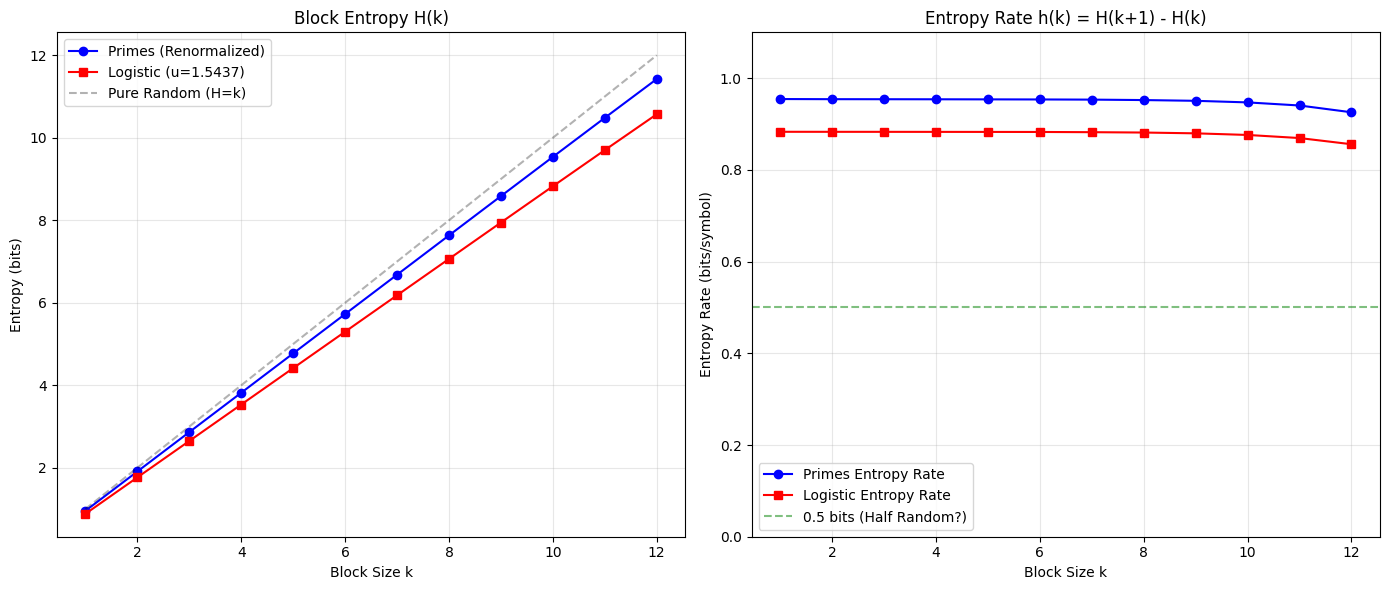


结果解读：
1. 观察 H(k) 的增长斜率。如果两者重合，说明它们携带信息的'密度'是一致的。
2. 观察 h(k) 的收敛值。随着 k 增大，h(k) 会趋向于系统的真实柯尔莫哥洛夫-西奈熵 (KS Entropy)。
   - 如果 h(k) 趋向于 1，说明是完全随机噪声。
   - 如果 h(k) 趋向于 0，说明是周期系统。
   - 如果 h(k) 稳定在 0 和 1 之间（例如 0.4 - 0.6），则有力证明了两者都是'确定性混沌'系统。
3. 如果红线(Logistic)和蓝线(Prime)在走势上高度贴合，这是两者具有相同动力学复杂度的强有力证据。


In [5]:
main()